# LoRaDongle Data Analysis Notebook

# Useful Links:

1. [Select Row from DataFrame based on Column Value](https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values)
2. [Get Cell Value from Dataframe](https://sparkbyexamples.com/pandas/pandas-get-cell-value-from-dataframe/)
3. [How to Fix in Pandas: KeyError: “[‘Label’] not found in axis”](https://www.statology.org/pandas-keyerror-label-not-found-in-axis/)
4. [Seaborn Tutorial in Python For Beginners](https://www.mygreatlearning.com/blog/seaborn-tutorial/)
5. [Github for useful plotting library](https://github.com/garrettj403/SciencePlots)
6. [Pandas Plotting Info (describes the different kinds of plots)](https://www.dataquest.io/blog/plot-dataframe-pandas/)

In [169]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [170]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [171]:
pip install seaborn 

Note: you may need to restart the kernel to use updated packages.


In [172]:
pip install scienceplots

Note: you may need to restart the kernel to use updated packages.


In [173]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


## Imports
Starts with importing the relevant packages

In [174]:
import csv, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scienceplots
import scipy

#sns.reset_orig()

## Global Variables
The variables that will be used in the notebook:
* List of the directories
* Data stored in a dictionary of lists, with the directories being keys and the list having csvs in a dataframe

In [175]:
data = {}
directories = ['latency_tests/','menzies_tests/','parkade_tests/', 'outdoor_cbd/', 'outdoor_los/']

# Reading Information CSVs
(Will likely be more important for actual analysis)

In [176]:
#for i, directory in enumerate(directories):
#    csv_name = directory + 'tests_info.csv'
#    info[directory] = pd.read_csv(csv_name)

#info[directories[0]] = pd.read_csv('latency_tests/tests_info.csv')
#print(info)

latency_info =  pd.read_csv('latency_tests/tests_info.csv')
indoor_tests_info = pd.read_csv('parkade_tests/tests_info.csv')
line_of_sight_info = pd.read_csv('outdoor_los/tests_info.csv')
#cbd_info = pd.read_csv('outdoor_cbd/tests_info.csv')

# Reading Data CSVs
(probably not useful)

In [177]:
for i, directory in enumerate(directories):
    count = 0
    data[directory] = []
    for path in os.listdir(directory):
        # check if current path is a file
        if os.path.isfile(os.path.join(directory, path)):
            count += 1
        
    print(f'File count in {directory}:  {count}')

    #reading every csv, might need to keep track of test_number? or read csv indiviaidually!
    #for j in range(1,count):
    #    csv_name = directories[i] + 'Test_' + str(j) + '.csv'
        #print(csv_name)
   #     data[directory].append(pd.read_csv(csv_name))
        


File count in latency_tests/:  17
File count in menzies_tests/:  14
File count in parkade_tests/:  37
File count in outdoor_cbd/:  7
File count in outdoor_los/:  7


# Analysis Plan
With CSVs read, the goal is to print graphs for all the tests performed. Graphs should tell me things such as:
* Percentage of successful messages
* Average transmit latency
* Average Round Time Latencies
* Graph of SNRs and RSSIs
  * Distance vs RSSI
  * Distance vs SNR


New plan for reading and handling csvs:
It seems like it would be easier to use tests_info.csv to iterate through CSVs in that folder and then extract the information you need from each csv. As opposed to reading all of them at once and struggling through.

Advice from mauro: load all csvs into a large dataframe and add columns from the tests_info.csv. that way can just filter out the various sections needed for analysis and plotting. will try implement that.

# Latency Analysis
Probably best to show it as a table. Should show average latency for each configuration! Therefore, iterate through config csvs and extract the necessary data
Basically create a new dataframe of read CSVs

Structure of analysis:
For every line in  test_info.csv (which is a test descriptor), read the corresponding csv and extract the average latency.
Then store it in the master latency dataframe.

## Setting up Dictionaries

In [178]:
latency_columns = ['Configuration',"4 Bytes", "15 Bytes"]
ldro_columns = ["Configuration", "LDRO 0", "LDRO 1"]
latencytx_results = {}
latencyrx_results = {}
ldro4_results = {"Configuration": [3,6], "LDRO 0": [], "LDRO 1": []}
ldro15_results = {"Configuration": [3,6], "LDRO 0": [], "LDRO 1": []}


for column in latency_columns:
    latencytx_results[column] = []        #Initialising dictionary keys with empty lists
    latencyrx_results[column] = []


## Separating Information files
Creates 3 distinct dataframes:
- Dataframe containing tests with four bytes long and no LDRO
- Dataframe containing tests with fifteen bytes long and no LDRO
- Dataframe containing tests with LDRO enabled

In [179]:

# extracting tests with 4 message size
four_byte_messages = latency_info.loc[latency_info["Message Size"] == 4][latency_info["LDRO"] == 0]
fifteen_byte_messages = latency_info.loc[latency_info["Message Size"] == 15][latency_info["LDRO"] == 0]
ldro_messages = latency_info.loc[latency_info["LDRO"] == 1]

#print(ldro_messages)
#print(four_byte_messages)
#print(fifteen_byte_messages)


test4_nums = four_byte_messages["Test Number"].tolist()
configs4=four_byte_messages["Configuration"].to_list()
# {Test Number: Configuration}
test4_configs = four_byte_messages.set_index("Test Number").to_dict()["Configuration"]
print(test4_configs)


test15_nums = fifteen_byte_messages["Test Number"].tolist()
configs15=fifteen_byte_messages["Configuration"].to_list()
# {Test Number: Configuration}
test15_configs = fifteen_byte_messages.set_index("Test Number").to_dict()["Configuration"]
print(test15_configs)


test_ldro_nums = ldro_messages["Test Number"].tolist()
configs_ldro=ldro_messages["Configuration"].to_list()
# {Test Number: Configuration}
ldro_configs = ldro_messages.set_index("Test Number").to_dict()["Configuration"]
print(ldro_configs)


{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
{9: 1, 10: 2, 11: 3, 13: 4, 14: 5, 15: 6}
{7: 3, 8: 6, 12: 3, 16: 6}


/tmp/ipykernel_29401/178481366.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  four_byte_messages = latency_info.loc[latency_info["Message Size"] == 4][latency_info["LDRO"] == 0]
/tmp/ipykernel_29401/178481366.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fifteen_byte_messages = latency_info.loc[latency_info["Message Size"] == 15][latency_info["LDRO"] == 0]


## Reading test files and popuplating result dictionaries

### Tests with 4 bytes and no LDRO

In [180]:
# reading through the test 4 no ldro files
for test_num, configuration in test4_configs.items():       #Iterating through tests with current floor difference
    #opening csv
    csv_name = "latency_tests/Test_" + str(test_num) + ".csv"
    test_csv = pd.read_csv(csv_name)

    #dealing with LDRO
    if configuration == 3 or configuration == 6:
        # want to also store success rate
        #ldro4_results["Configuration"].append(configuration)

        # Counting the number of trues for current test, converting to dictionary
        current_success_rate = test_csv['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
        current_success_rate = current_success_rate.to_dict()
        ldro4_results["LDRO 0"].append(current_success_rate[True] * 100)
    
    #obtaining average tx latency
    average_latency = test_csv["Time to Send"].mean()
    #print(average_latency)
    latencytx_results['4 Bytes'].append(int(round(average_latency,0)))
    latencytx_results['Configuration'].append(configuration)


    #obtaining average round trip latency
    average_latency = test_csv["Time to Receive"].mean()
    #print(average_latency)
    latencyrx_results['4 Bytes'].append(int(round(average_latency,0)))
    latencyrx_results['Configuration'].append(configuration)


print(ldro4_results)
print(latencytx_results)
print(latencyrx_results)


{'Configuration': [3, 6], 'LDRO 0': [13.20754716981132, 85.29411764705883], 'LDRO 1': []}
{'Configuration': [1, 2, 3, 4, 5, 6], '4 Bytes': [549, 2762, 9236, 699, 3601, 12067], '15 Bytes': []}
{'Configuration': [1, 2, 3, 4, 5, 6], '4 Bytes': [1194, 5635, 18630, 1491, 7314, 24294], '15 Bytes': []}


### Tests with 15 bytes and no LDRO

In [181]:
for test_num, configuration in test15_configs.items():       #Iterating through tests with current floor difference
    #opening csv
    csv_name = "latency_tests/Test_" + str(test_num) + ".csv"
    test_csv = pd.read_csv(csv_name)

    #dealing with LDRO
    if configuration == 3 or configuration == 6:
        # want to also store success rate
        #ldro15_results["Configuration"].append(configuration)

        # Counting the number of trues for current test, converting to dictionary
        current_success_rate = test_csv['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
        current_success_rate = current_success_rate.to_dict()
        ldro15_results["LDRO 0"].append(100 - (current_success_rate[False] * 100))
    
    #obtaining average tx latency
    average_latency = test_csv["Time to Send"].mean()
    #print(average_latency)
    latencytx_results['15 Bytes'].append(int(round(average_latency,0)))
    #latencytx_results['Configuration'].append(configuration)


    #obtaining average round trip latency
    average_latency = test_csv["Time to Receive"].mean()
    #print(average_latency)
    latencyrx_results['15 Bytes'].append(int(round(average_latency,0)))
    #latencyrx_results['Configuration'].append(configuration)


print(ldro15_results)
print(latencytx_results)
print(latencyrx_results)

{'Configuration': [3, 6], 'LDRO 0': [0.0, 0.0], 'LDRO 1': []}
{'Configuration': [1, 2, 3, 4, 5, 6], '4 Bytes': [549, 2762, 9236, 699, 3601, 12067], '15 Bytes': [565, 2778, 9252, 715, 3617, 12082]}
{'Configuration': [1, 2, 3, 4, 5, 6], '4 Bytes': [1194, 5635, 18630, 1491, 7314, 24294], '15 Bytes': [1249, 5693, 18682, 1553, 7372, 24346]}


### Tests with LDRO activated

In [182]:
print("LDRO Results:")

for test_num, configuration in ldro_configs.items():       #Iterating through tests with current floor difference
    #opening csv
    csv_name = "latency_tests/Test_" + str(test_num) + ".csv"
    test_csv = pd.read_csv(csv_name)

    if test_num <= 8:
        #ldro4_results["Configuration"].append(configuration)

        # Counting the number of trues for current test, converting to dictionary
        current_success_rate = test_csv['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
        current_success_rate = current_success_rate.to_dict()
        ldro4_results["LDRO 1"].append(current_success_rate[True] * 100)
        average_latency = test_csv["Time to Send"].mean()
        print("Average Tx Latency for Config", configuration)
        print(int(round(average_latency,0)))

    else:
        #ldro15_results["Configuration"].append(configuration)

        # Counting the number of trues for current test, converting to dictionary
        current_success_rate = test_csv['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
        current_success_rate = current_success_rate.to_dict()
        ldro15_results["LDRO 1"].append(current_success_rate[True] * 100)
        average_latency = test_csv["Time to Send"].mean()
        print("Average Tx Latency for Config", configuration)
        print(int(round(average_latency,0)))


print(ldro4_results)
print(ldro15_results)

LDRO Results:
Average Tx Latency for Config 3
10816
Average Tx Latency for Config 6
14173
Average Tx Latency for Config 3
10832
Average Tx Latency for Config 6
14189
{'Configuration': [3, 6], 'LDRO 0': [13.20754716981132, 85.29411764705883], 'LDRO 1': [100.0, 100.0]}
{'Configuration': [3, 6], 'LDRO 0': [0.0, 0.0], 'LDRO 1': [100.0, 100.0]}


### Creating dataframes from dictionaries

In [183]:
ldro4_df = pd.DataFrame.from_dict(ldro4_results)
ldro15_df = pd.DataFrame.from_dict(ldro15_results)

latencytx_df = pd.DataFrame.from_dict(latencytx_results)
latencyrx_df = pd.DataFrame.from_dict(latencyrx_results)

print("The latencies for transmission are as follows:")
print(latencytx_df)


print("The latencies for round trip are as follows:")
print(latencyrx_df)


The latencies for transmission are as follows:
   Configuration  4 Bytes  15 Bytes
0              1      549       565
1              2     2762      2778
2              3     9236      9252
3              4      699       715
4              5     3601      3617
5              6    12067     12082
The latencies for round trip are as follows:
   Configuration  4 Bytes  15 Bytes
0              1     1194      1249
1              2     5635      5693
2              3    18630     18682
3              4     1491      1553
4              5     7314      7372
5              6    24294     24346


### Plotting LDRO Success Rate in a bar chart

   Configuration     LDRO 0  LDRO 1
0              3  13.207547   100.0
1              6  85.294118   100.0


<AxesSubplot: title={'center': 'LDRO Effect on Success Rate, 15 bytes of Data'}, xlabel='Configuration', ylabel='Success Rate %'>

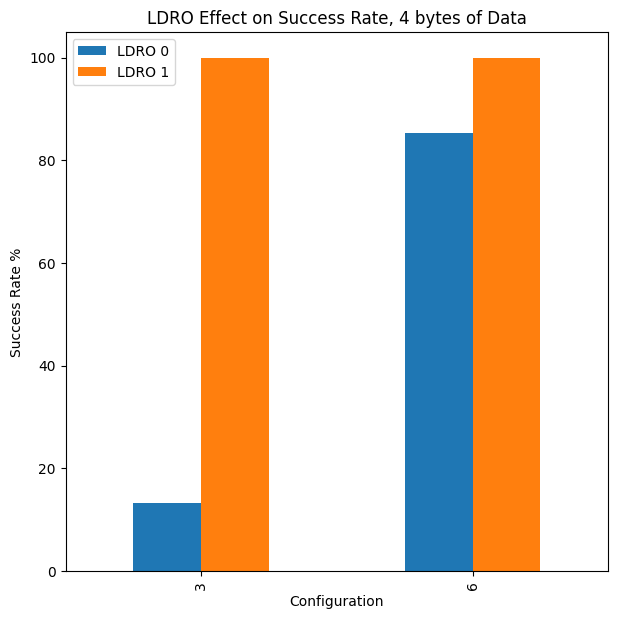

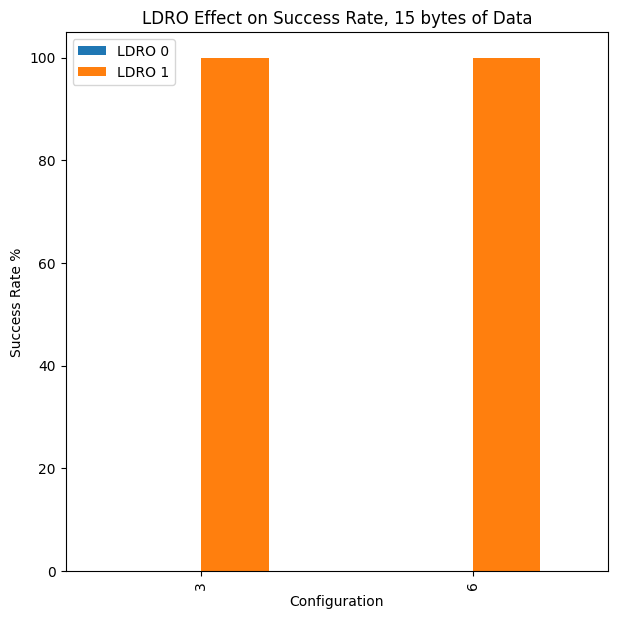

In [184]:
print(ldro4_df)

ldro4_df.plot(kind="bar", x='Configuration', title='LDRO Effect on Success Rate, 4 bytes of Data', ylabel="Success Rate %", figsize=[7,7], legend=True)
ldro15_df.plot(kind="bar", x='Configuration', title='LDRO Effect on Success Rate, 15 bytes of Data', ylabel="Success Rate %", figsize=[7,7], legend=True)



In [185]:
latency_columns = ['Test', "Average Tx Time", "Average Round Trip Time"]#, "Max Tx Time", "Min Tx Time"]  #for now, configuration corresponds to test number, for latency testing there should really be only six tests
latency_results = {}

for column in latency_columns:
    latency_results[column] = []        #Initialising dictionary keys with empty lists


#obtaining the list of tests (hence files) in the directory
tests = latency_info["Test Number"].tolist()

#opening and extracting necessary info per csv
for test_num in tests:

    test_config = latency_info.loc[latency_info["Test Number"] == test_num]["Configuration"]
    #print(test_config) TODO: get the config of the test number and then use that to append to latency results configuration list

    #start with adding the configuration to latency results
    latency_results['Test'].append(test_num)

    #reading required test csv
    csv_name =   "latency_tests/Test_" + str(test_num) + ".csv"
    test_csv = pd.read_csv(csv_name)

    #### Obtaining Average Tx
    average_latency = test_csv["Time to Send"].mean()
    #print(average_latency)
    latency_results['Average Tx Time'].append(int(round(average_latency,0)))

    ### Obtaining Average Rx
    average_rx = test_csv["Time to Receive"].mean()
    latency_results['Average Round Trip Time'].append(int(round(average_rx,0)))

    #### Obtaining Max
    max_latency = test_csv["Time to Send"].max()
    #latency_results['Max Tx Time'].append(int(round(max_latency, 0)))

    #### Obtaining Min
    min_latency = test_csv["Time to Send"].min()
    #latency_results['Min Tx Time'].append(int(round(min_latency, 0)))


#convert results to dataframe
latency_df = pd.DataFrame.from_dict(latency_results)
print(latency_df)

    Test  Average Tx Time  Average Round Trip Time
0      1              549                     1194
1      2             2762                     5635
2      3             9236                    18630
3      4              699                     1491
4      5             3601                     7314
5      6            12067                    24294
6      7            10816                    21792
7      8            14173                    28506
8      9              565                     1249
9     10             2778                     5693
10    11             9252                    18682
11    12            10832                    21850
12    13              715                     1553
13    14             3617                     7372
14    15            12082                    24346
15    16            14189                    28566


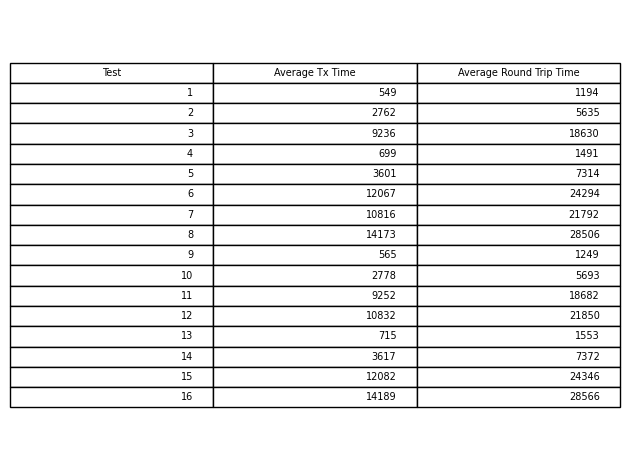

In [186]:

###############################Plotting table#################################### (just to see in table form, not needed for final graph)
# (Not that useful for final report)


#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#create table
table = ax.table(cellText=latency_df.values, colLabels=latency_df.columns, loc='center')

#display table
fig.tight_layout()
plt.show()

# Indoor Testing Analysis
Want to display the data as how each configuration responds due to the floor difference. So for example will look at a dloor differnce of two, will want to plot the % success rate of each configuration, the snr and rssi's of the configs as well.

The story to be told is eg: "looking at floor 3, configs 5-6 performed much better than configs 1-2"

Processing challenge will be:
1. Read info file
2. Filter by floor difference, horizontal distance
3. then filter by config
4. then read the test csvs of that config and that floor differnce
5. Pull the necessary data, appending it to whatever new dataframe that you have that will then plot the graphs.
6. Rinse and repeat

In [187]:
# Creating Averages as a Dataframes/Dictionary (SNR and RSSI)
average_snr = {"Floors": [1,2,3,4], "Config 1" : [], "Config 2": [], "Config 2": [], "Config 3": [], "Config 4": [], "Config 5": [], "Config 6": []}
average_rssi = {"Floors": [1,2,3,4], "Config 1" : [], "Config 2": [], "Config 2": [], "Config 3": [], "Config 4": [], "Config 5": [], "Config 6": []}


average_snr_horizontal = {"Floors": [2,4], "Config 1" : [], "Config 2": [], "Config 2": [], "Config 3": [], "Config 4": [], "Config 5": [], "Config 6": []}
average_rssi_horizontal = {"Floors": [2,4], "Config 1" : [], "Config 2": [], "Config 2": [], "Config 3": [], "Config 4": [], "Config 5": [], "Config 6": []}


## 1 Floor Difference

### Parsing Data
Generating the list of and dictionary of all tests done with one floor difference

In [188]:

# Extract files info with 1 floor difference
floor_1_diff = indoor_tests_info.loc[indoor_tests_info["Floor Difference"] == 1]
#print(floor_1_diff.head())

test_nums = floor_1_diff["Test Number"].tolist()
configs=floor_1_diff["Configuration"].to_list()
#print(configs)
#print(test_nums)

# {Test Number: Configuration}
test_configs = floor_1_diff.set_index("Test Number").to_dict()["Configuration"]
print(test_configs)
#print(floor_1_diff["Configuration"])


{3: 1, 4: 2, 7: 3, 10: 4, 13: 5, 16: 6}


### Success Rate
Breaking down csvs and creating one dataframe that stores success rate of the six different configs over one floor difference


In [189]:
#print(indoor_tests_info)
success_rate_columns = ["Configuration", "Success Rate"]
success_rate_dict = {}

for column in success_rate_columns:
    success_rate_dict[column] = []


In [190]:
# Going through tests ad obtaining %passes per test
for test_num in test_nums:
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    
    # Counting the number of trues for current test, converting to dictionary
    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    current_success_rate = current_success_rate.to_dict()

    success_rate_dict["Configuration"].append(test_configs[test_num])
    success_rate_dict["Success Rate"].append(current_success_rate[True] * 100)



success_rate_df = pd.DataFrame.from_dict(success_rate_dict)

#### Plotting Graph (?)
Basically best way to show the success rate of the first floor tests, thinking just a table is good enough. May want to use a bar graph though.

In [191]:
print("Success Rate for diffierent configurations at 1 floor difference:")
print(success_rate_df)


Success Rate for diffierent configurations at 1 floor difference:
   Configuration  Success Rate
0              1    100.000000
1              2    100.000000
2              3     96.666667
3              4     96.551724
4              5    100.000000
5              6     96.666667


### RSSI, RSSI Despread and SNR

Need to figure out difference between rssi and rssi despread

#### 1. Setting up Dataframe column titles

In [192]:
# May not be necessary for adding to the list easily
rssi_columns = ["Config", "RSSI", "Rssi Despread"]
columns = ["Configuration 1", "Configuration 2", "configuration 3", "Configuration 4", "Configuration 5", "Configuration 6"]
rssi_dict = {}
rssi_d_dict = {}
snr_dict = {}


#### 2. Obtaining RSSI Value for all 1st floor transmits

In [193]:
for test_num, configuration in test_configs.items():       #Iterating through tests with current floor difference
    test_name =     test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)
    
    #print("Test Number " + str(test_num) + ", With configuration " + str(configuration))
    rssis = test_df['RSSI'].to_list()
    rssi_ds = test_df['RSSI Despread'].to_list()
    snrs = test_df['SNR'].to_list()
    
    rssi_dict[str(configuration)] = rssis
    rssi_d_dict[str(configuration)] = rssi_ds
    snr_dict[str(configuration)] = snrs
    

rssi_df_1floor = pd.DataFrame.from_dict(rssi_dict)
rssid_df_1floor = pd.DataFrame.from_dict(rssi_d_dict)
snr_df_1floor = pd.DataFrame.from_dict(snr_dict)

#### 4. Plotting

<AxesSubplot: title={'center': 'SNR For Six Configurations at 1 Floor Difference'}, xlabel='Ping ID', ylabel='SNR'>

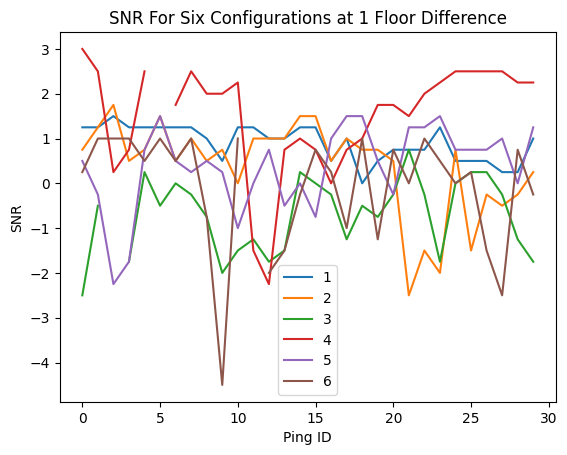

In [194]:
# Signal to noise ratios
snr_df_1floor.plot(title="SNR For Six Configurations at 1 Floor Difference", ylabel="SNR", xlabel="Ping ID")

Average SNR For each config:
1    0.908333
2    0.375000
3   -0.715517
4    1.508621
5    0.375000
6   -0.103448
dtype: float64
Average RSSI For each config:
1   -41.016667
2   -41.666667
3   -42.672414
4   -44.896552
5   -45.900000
6   -46.672414
dtype: float64
Average RSSI Despread For each config:
1   -41.650000
2   -42.716667
3   -45.258621
4   -45.586207
5   -46.933333
6   -48.948276
dtype: float64


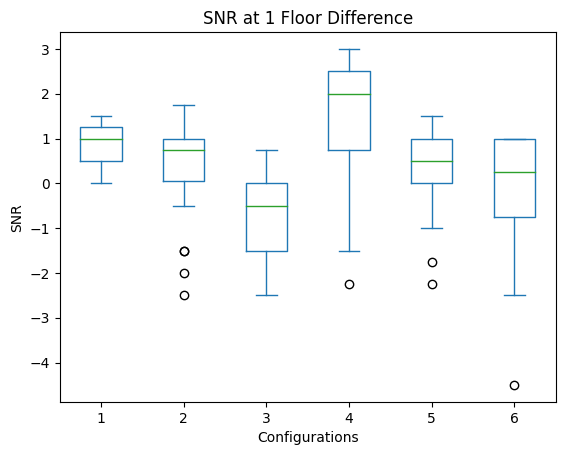

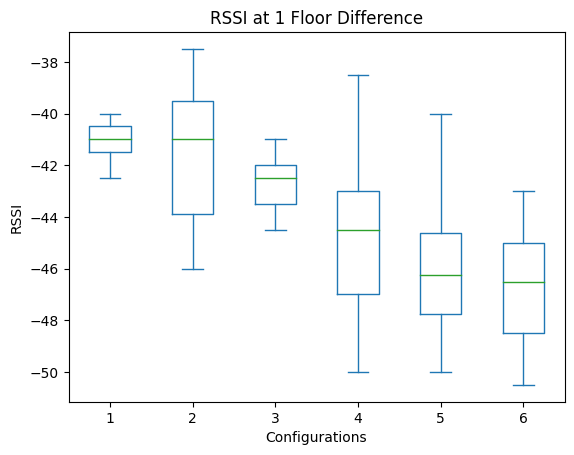

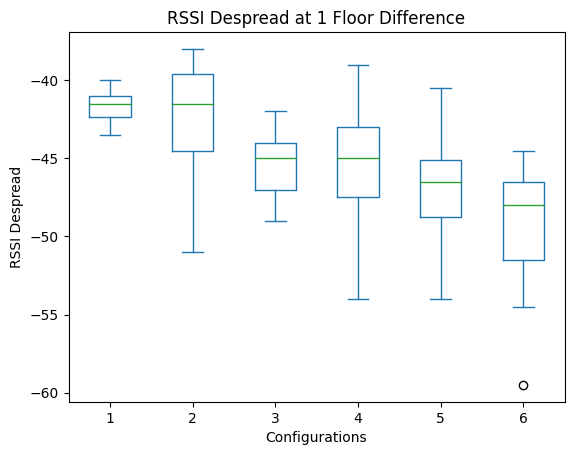

In [195]:
snr_df_1floor.plot(kind="box", title="SNR at 1 Floor Difference",ylabel="SNR", xlabel="Configurations")
snr_1_mean = snr_df_1floor.mean()
print("Average SNR For each config:")
print(snr_1_mean)

rssi_df_1floor.plot(kind="box", title="RSSI at 1 Floor Difference",ylabel="RSSI", xlabel="Configurations")
print("Average RSSI For each config:")
rssi_1_mean = rssi_df_1floor.mean()
print(rssi_1_mean)


rssid_df_1floor.plot(kind="box", title="RSSI Despread at 1 Floor Difference",ylabel="RSSI Despread", xlabel="Configurations")
rssid_1_mean = rssid_df_1floor.mean()
print("Average RSSI Despread For each config:")
print(rssid_1_mean)

# appending to summary dictionaries
for config, mean in snr_1_mean.to_dict().items():
    average_snr["Config " + config].append(mean)


for config, mean in rssid_1_mean.to_dict().items():
    average_rssi["Config " + config].append(mean)

#print(average_snr)

## 2 Floor Difference

### Parsing Data

In [196]:

# Extract files info with 2 floor difference
floor_2_diff = indoor_tests_info.loc[indoor_tests_info["Floor Difference"] == 2]
no_horizontal = floor_2_diff.loc[floor_2_diff["Horizontal Distance"] == 0]
with_horizontal = floor_2_diff.loc[floor_2_diff["Horizontal Distance"] == 50]

# {Test Number: Configuration}
test_configs_2no = no_horizontal.set_index("Test Number").to_dict()["Configuration"]
print(test_configs_2no)

test_configs_2with = with_horizontal.set_index("Test Number").to_dict()["Configuration"]
print(test_configs_2with)

{1: 1, 5: 2, 8: 3, 11: 4, 14: 5, 17: 6}
{19: 1, 22: 2, 25: 3, 28: 4, 31: 5, 34: 6}


### Success Rate
Finding success rate of the six different configurations

In [197]:
# Initilisaing dictionary
#success_rate_columns = ["Configuration", "Success Rate"]
success_rate2_dict = {}
success_rate2w_dict = {}
for column in success_rate_columns:
    success_rate2_dict[column] = []
    success_rate2w_dict[column] = []


# Going through tests and obtaining %passes per test (no horizontal tests)
for test_num, configuration in test_configs_2no.items():
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    
    # Counting the number of trues for current test, converting to dictionary
    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    current_success_rate = current_success_rate.to_dict()

    success_rate2_dict["Configuration"].append(configuration)
    success_rate2_dict["Success Rate"].append(current_success_rate[True] * 100)

#horizontal tests
for test_num, configuration in test_configs_2with.items():
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    
    # Counting the number of trues for current test, converting to dictionary
    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    current_success_rate = current_success_rate.to_dict()

    success_rate2w_dict["Configuration"].append(configuration)
    success_rate2w_dict["Success Rate"].append(current_success_rate[True] * 100)


success_rate2_df = pd.DataFrame.from_dict(success_rate2_dict)
success_rate2w_df = pd.DataFrame.from_dict(success_rate2w_dict)


#### Visualisation

In [198]:
print("Success Rate for diffierent configurations at 2 floor difference:")
print(success_rate2_df)


print("Success Rate for diffierent configurations at 2 floor difference and horizontal distance:")
print(success_rate2w_df)

Success Rate for diffierent configurations at 2 floor difference:
   Configuration  Success Rate
0              1     93.333333
1              2    100.000000
2              3     93.333333
3              4    100.000000
4              5     96.666667
5              6     93.333333
Success Rate for diffierent configurations at 2 floor difference and horizontal distance:
   Configuration  Success Rate
0              1     13.333333
1              2     63.333333
2              3     93.333333
3              4     80.000000
4              5     86.666667
5              6     83.333333


### RSSI, RSSI Despread and SNR

In [199]:
# Setting up Dataframes
columns = ["Configuration 1", "Configuration 2", "configuration 3", "Configuration 4", "Configuration 5", "Configuration 6"]
rssi_dict = {}
rssi_d_dict = {}
snr_dict = {}


# Obtaining Values
for test_num, configuration in test_configs_2no.items():       #Iterating through tests with current floor difference
    test_name =     test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)
    
    #print("Test Number " + str(test_num) + ", With configuration " + str(configuration))
    rssis = test_df['RSSI'].to_list()
    #print(len(rssis))
    rssi_ds = test_df['RSSI Despread'].to_list()
    snrs = test_df['SNR'].to_list()
    
    rssi_dict[str(configuration)] = rssis
    rssi_d_dict[str(configuration)] = rssi_ds
    snr_dict[str(configuration)] = snrs
    

rssi_df_2nfloor = pd.DataFrame.from_dict(rssi_dict)
print(rssi_df_2nfloor.head())
rssid_df_2nfloor = pd.DataFrame.from_dict(rssi_d_dict)
snr_df_2nfloor = pd.DataFrame.from_dict(snr_dict)



      1     2     3     4     5     6
0 -42.5 -44.5 -33.0 -41.0 -41.5 -42.5
1 -43.0 -44.5 -40.5 -42.0 -43.5   NaN
2 -43.0 -45.0 -39.0 -44.0 -41.5 -45.5
3 -42.5 -44.5 -41.5 -44.0 -45.5 -46.0
4 -42.5 -44.5 -39.0 -42.5 -44.0 -49.0


In [200]:
rssi_dict = {}
rssi_d_dict = {}
snr_dict = {}


# Obtaining Values
for test_num, configuration in test_configs_2with.items():       #Iterating through tests with current floor difference
    test_name =     test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)
    
    #print("Test Number " + str(test_num) + ", With configuration " + str(configuration))
    rssis = test_df['RSSI'].to_list()
    #print(len(rssis))
    rssi_ds = test_df['RSSI Despread'].to_list()
    snrs = test_df['SNR'].to_list()
    
    rssi_dict[str(configuration)] = rssis
    rssi_d_dict[str(configuration)] = rssi_ds
    snr_dict[str(configuration)] = snrs
    






rssi_df_2wfloor = pd.DataFrame.from_dict(rssi_dict)
rssi_df_2wfloor = rssi_df_2wfloor.drop('1', axis=1)
print(rssi_df_2wfloor.head())

rssid_df_2wfloor = pd.DataFrame.from_dict(rssi_d_dict)
#appending to rssid mean dictionary
for config, mean in rssid_df_2wfloor.mean().to_dict().items():
    average_rssi_horizontal["Config " + config].append(mean)

rssid_df_2wfloor = rssid_df_2wfloor.drop('1', axis=1)


snr_df_2wfloor = pd.DataFrame.from_dict(snr_dict)
# appending to summary dictionaries
for config, mean in snr_df_2wfloor.mean().to_dict().items():
    average_snr_horizontal["Config " + config].append(mean)

snr_df_2wfloor = snr_df_2wfloor.drop('1', axis=1)


      2     3     4     5     6
0 -49.5 -46.5 -48.5 -49.5 -48.0
1 -50.0 -47.5 -49.0 -49.0 -47.5
2 -50.0 -48.0 -50.0 -50.5 -48.0
3   NaN -47.0 -47.5 -50.0 -48.0
4   NaN -48.0 -48.0 -49.0 -49.0


#### Plotting the results

Average SNR For each config:
1   -0.848214
2    0.308333
3    1.517857
4    2.316667
5    0.431034
6    0.651786
dtype: float64
Average RSSI For each config:
1   -43.285714
2   -43.650000
3   -40.339286
4   -42.716667
5   -45.241379
6   -44.875000
dtype: float64
Average RSSI Despread For each config:
1   -45.714286
2   -44.733333
3   -41.196429
4   -43.116667
5   -46.327586
6   -46.107143
dtype: float64


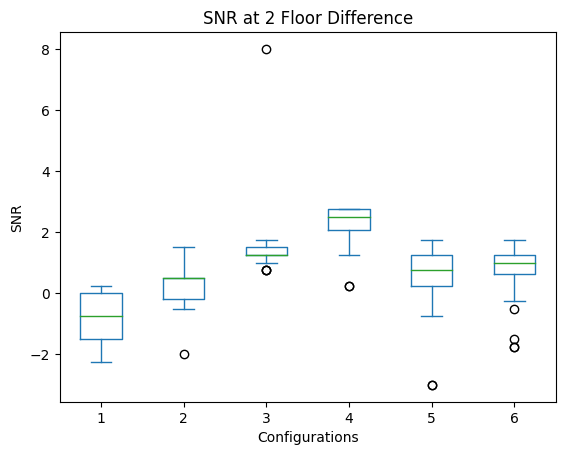

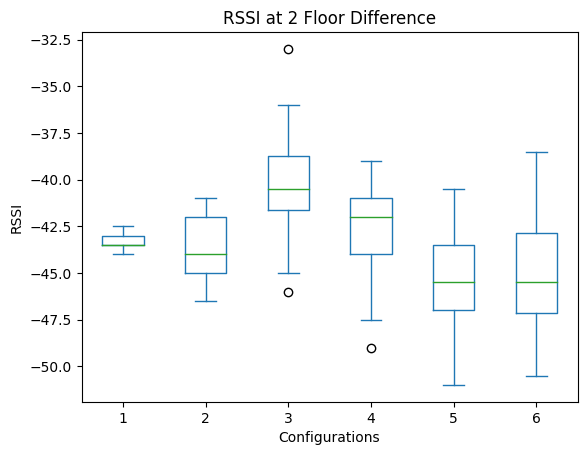

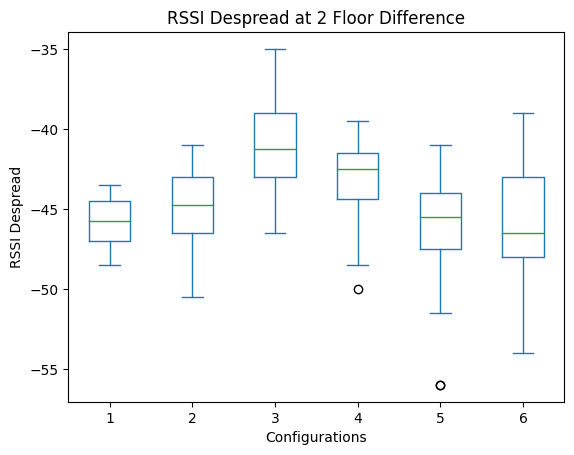

In [201]:
snr_df_2nfloor.plot(kind="box", title="SNR at 2 Floor Difference",ylabel="SNR", xlabel="Configurations")
snr_2n_mean = snr_df_2nfloor.mean()
print("Average SNR For each config:")
print(snr_2n_mean)

rssi_df_2nfloor.plot(kind="box", title="RSSI at 2 Floor Difference",ylabel="RSSI", xlabel="Configurations")
print("Average RSSI For each config:")
rssi_2n_mean = rssi_df_2nfloor.mean()
print(rssi_2n_mean)


rssid_df_2nfloor.plot(kind="box", title="RSSI Despread at 2 Floor Difference",ylabel="RSSI Despread", xlabel="Configurations")
rssid_2n_mean = rssid_df_2nfloor.mean()
print("Average RSSI Despread For each config:")
print(rssid_2n_mean)


# appending to summary dictionaries
for config, mean in snr_2n_mean.to_dict().items():
    average_snr["Config " + config].append(mean)


for config, mean in rssid_2n_mean.to_dict().items():
    average_rssi["Config " + config].append(mean)

Average SNR For each config:
2   -4.125000
3   -1.183333
4   -1.093750
5   -2.634615
6   -2.096154
dtype: float64
Average RSSI For each config:
2   -50.350000
3   -47.933333
4   -48.354167
5   -49.269231
6   -48.461538
dtype: float64
Average RSSI Despread For each config:
2   -58.200000
3   -51.450000
4   -50.958333
5   -54.576923
6   -53.153846
dtype: float64


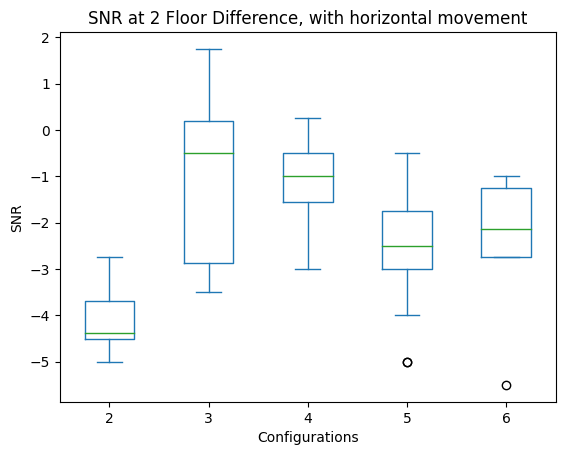

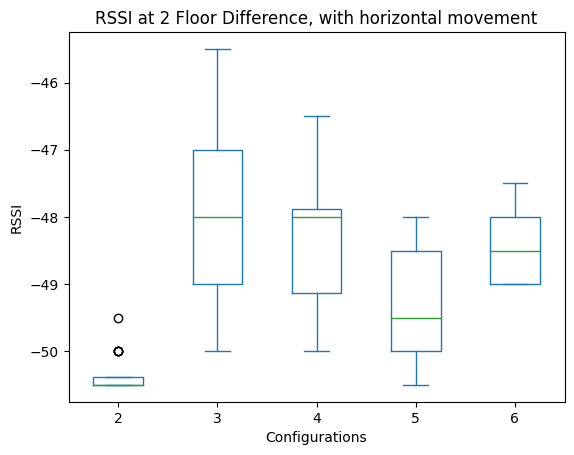

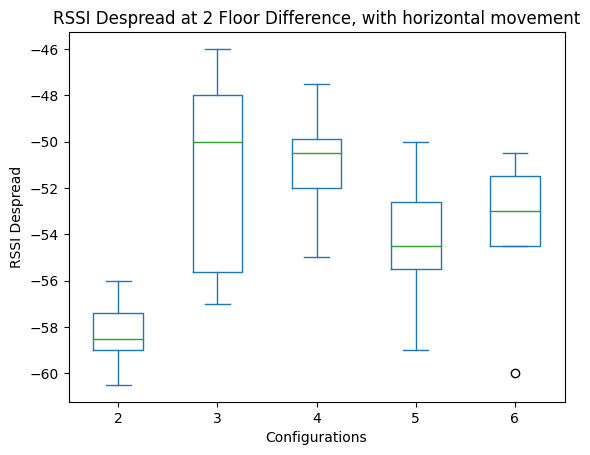

In [202]:
snr_df_2wfloor.plot(kind="box", title="SNR at 2 Floor Difference, with horizontal movement",ylabel="SNR", xlabel="Configurations")
snr_2w_mean = snr_df_2wfloor.mean()
print("Average SNR For each config:")
print(snr_2w_mean)

rssi_df_2wfloor.plot(kind="box", title="RSSI at 2 Floor Difference, with horizontal movement",ylabel="RSSI", xlabel="Configurations")
print("Average RSSI For each config:")
rssi_2w_mean = rssi_df_2wfloor.mean()
print(rssi_2w_mean)


rssid_df_2wfloor.plot(kind="box", title="RSSI Despread at 2 Floor Difference, with horizontal movement",ylabel="RSSI Despread", xlabel="Configurations")
rssid_2w_mean = rssid_df_2wfloor.mean()
print("Average RSSI Despread For each config:")
print(rssid_2w_mean)


## 3 Floor Difference

### Parsing Data

In [203]:
# Extract files info with 3 floor difference
floor_3_diff = indoor_tests_info.loc[indoor_tests_info["Floor Difference"] == 3]
#no_horizontal = floor_3_diff.loc[floor_3_diff["Horizontal Distance"] == 0]
#with_horizontal = floor_3_diff.loc[floor_3_diff["Horizontal Distance"] == 50]

# {Test Number: Configuration}
test_configs_3 = floor_3_diff.set_index("Test Number").to_dict()["Configuration"]
print("Test Number: Configuration Number")
print(test_configs_3)

Test Number: Configuration Number
{2: 1, 6: 2, 9: 3, 12: 4, 15: 5, 18: 6}


### Success Rate

In [204]:
# Initilisaing dictionary
success_rate3_dict = {}
for column in success_rate_columns:
    success_rate3_dict[column] = []


# Going through tests and obtaining %passes per test
for test_num, configuration in test_configs_3.items():
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    
    # Counting the number of trues for current test, converting to dictionary
    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    current_success_rate = current_success_rate.to_dict()

    success_rate3_dict["Configuration"].append(configuration)
    success_rate3_dict["Success Rate"].append(current_success_rate[True] * 100)



success_rate3_df = pd.DataFrame.from_dict(success_rate3_dict)

#### Visualisation

In [205]:
print("Success Rate for diffierent configurations at 3 floor difference:")
print(success_rate3_df)

Success Rate for diffierent configurations at 3 floor difference:
   Configuration  Success Rate
0              1     30.000000
1              2    100.000000
2              3     96.666667
3              4    100.000000
4              5    100.000000
5              6     96.666667


### RSSI, RSSI Despread and SNR

In [206]:
# Setting up Dataframes
rssi_dict = {}
rssi_d_dict = {}
snr_dict = {}


# Obtaining Values
for test_num, configuration in test_configs_3.items():       #Iterating through tests with current floor difference
    test_name =     test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)
    
    #print("Test Number " + str(test_num) + ", With configuration " + str(configuration))
    rssis = test_df['RSSI'].to_list()
    print(len(rssis))
    rssi_ds = test_df['RSSI Despread'].to_list()
    snrs = test_df['SNR'].to_list()
    
    rssi_dict[str(configuration)] = rssis
    rssi_d_dict[str(configuration)] = rssi_ds
    snr_dict[str(configuration)] = snrs
    





rssi_df_3floor = pd.DataFrame.from_dict(rssi_dict)
rssi_df_3floor = rssi_df_3floor.drop('1', axis=1)
print(rssi_df_3floor.head())

rssid_df_3floor = pd.DataFrame.from_dict(rssi_d_dict)
#appending to rssid average
for config, mean in rssid_df_3floor.mean().to_dict().items():
    average_rssi["Config " + config].append(mean)
rssid_df_3floor = rssid_df_3floor.drop('1', axis=1)



snr_df_3floor = pd.DataFrame.from_dict(snr_dict)
# appending to summary dictionaries
for config, mean in snr_df_3floor.mean().to_dict().items():
    average_snr["Config " + config].append(mean)
snr_df_3floor = snr_df_3floor.drop('1', axis=1)

30
30
30
30
30
30
      2     3     4     5     6
0 -46.0 -40.0 -48.0 -49.5 -47.0
1 -46.5 -43.0 -44.0 -50.0 -49.0
2 -46.5 -45.5 -48.0 -47.5 -49.0
3 -47.0 -45.0 -47.5 -47.5 -48.5
4 -46.5 -41.0 -44.0 -49.0 -47.5


#### Plotting results

Average SNR For each config:
2   -1.341667
3    0.448276
4    0.425000
5   -0.433333
6   -0.241379
dtype: float64
Average RSSI For each config:
2   -45.933333
3   -45.000000
4   -47.516667
5   -47.416667
6   -46.534483
dtype: float64
Average RSSI Despread For each config:
2   -49.033333
3   -46.672414
4   -48.683333
5   -49.166667
6   -48.827586
dtype: float64


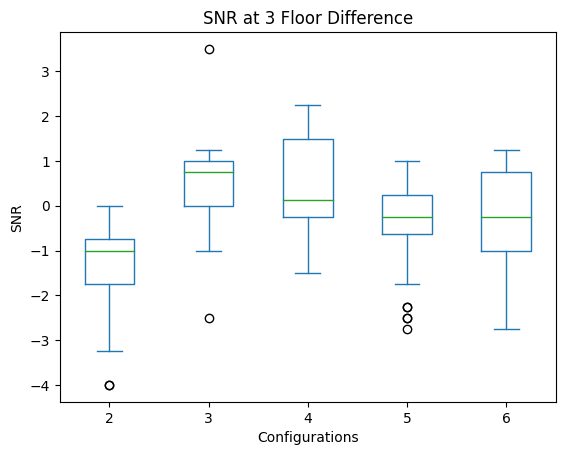

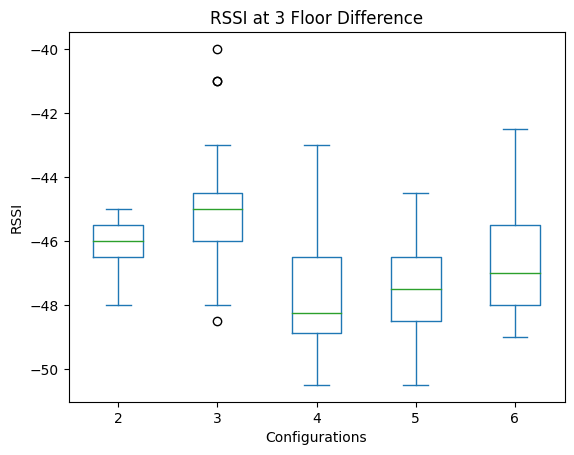

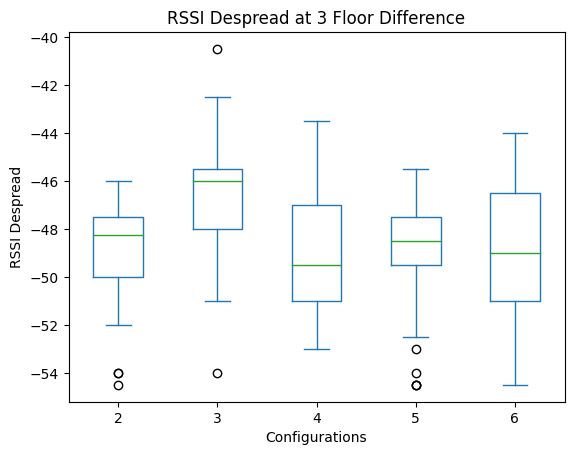

In [207]:
snr_df_3floor.plot(kind="box", title="SNR at 3 Floor Difference",ylabel="SNR", xlabel="Configurations")
snr_3_mean = snr_df_3floor.mean()
print("Average SNR For each config:")
print(snr_3_mean)

rssi_df_3floor.plot(kind="box", title="RSSI at 3 Floor Difference",ylabel="RSSI", xlabel="Configurations")
print("Average RSSI For each config:")
rssi_3_mean = rssi_df_3floor.mean()
print(rssi_3_mean)


rssid_df_3floor.plot(kind="box", title="RSSI Despread at 3 Floor Difference",ylabel="RSSI Despread", xlabel="Configurations")
rssid_3_mean = rssid_df_3floor.mean()
print("Average RSSI Despread For each config:")
print(rssid_3_mean)



## 4 Floor Difference

### Parsing Data

In [208]:

# Extract files info with 2 floor difference
floor_4_diff = indoor_tests_info.loc[indoor_tests_info["Floor Difference"] == 4]
no_horizontal = floor_4_diff.loc[floor_4_diff["Horizontal Distance"] == 0]
with_horizontal = floor_4_diff.loc[floor_4_diff["Horizontal Distance"] == 50]

# {Test Number: Configuration}
test_configs_4no = no_horizontal.set_index("Test Number").to_dict()["Configuration"]
print(test_configs_4no)

test_configs_4with = with_horizontal.set_index("Test Number").to_dict()["Configuration"]
print(test_configs_4with)

{20: 1, 23: 2, 26: 3, 29: 4, 32: 5, 35: 6}
{21: 1, 24: 2, 27: 3, 30: 4, 33: 5, 36: 6}


### Success Rate

In [209]:
# Initilisaing dictionary
#success_rate_columns = ["Configuration", "Success Rate"]
success_rate4n_dict = {}
success_rate4w_dict = {}
for column in success_rate_columns:
    success_rate4n_dict[column] = []
    success_rate4w_dict[column] = []

# Going through tests and obtaining %passes per test
for test_num, configuration in test_configs_4no.items():
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    
    # Counting the number of trues for current test, converting to dictionary
    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    current_success_rate = current_success_rate.to_dict()

    success_rate4n_dict["Configuration"].append(configuration)
    success_rate4n_dict["Success Rate"].append(100 - (current_success_rate[False] * 100))


# Going through tests and obtaining %passes per test
for test_num, configuration in test_configs_4with.items():
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    
    # Counting the number of trues for current test, converting to dictionary
    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    current_success_rate = current_success_rate.to_dict()

    success_rate4w_dict["Configuration"].append(configuration)
    success_rate4w_dict["Success Rate"].append(100 - (current_success_rate[False] * 100))



success_rate4n_df = pd.DataFrame.from_dict(success_rate4n_dict)
success_rate4w_df = pd.DataFrame.from_dict(success_rate4w_dict)

#### Visualisation

In [210]:
print("Success Rate for diffierent configurations at 4 floor difference:")
print(success_rate4n_df)

print("Success Rate for diffierent configurations at 4 floor difference, with horizontal movement:")
print(success_rate4w_df)

Success Rate for diffierent configurations at 4 floor difference:
   Configuration  Success Rate
0              1      0.000000
1              2     66.666667
2              3     80.000000
3              4     40.000000
4              5     83.333333
5              6     96.666667
Success Rate for diffierent configurations at 4 floor difference, with horizontal movement:
   Configuration  Success Rate
0              1      3.333333
1              2      6.666667
2              3     51.724138
3              4      3.333333
4              5     41.379310
5              6     63.333333


### RSSI, RSSI Despread and SNR

In [211]:
# Setting up Dataframes
rssi_dict = {}
rssi_d_dict = {}
snr_dict = {}


# Obtaining Values
for test_num, configuration in test_configs_4no.items():       #Iterating through tests with current floor difference
    test_name =     test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)
    
    #print("Test Number " + str(test_num) + ", With configuration " + str(configuration))
    rssis = test_df['RSSI'].to_list()
    #print(len(rssis))
    rssi_ds = test_df['RSSI Despread'].to_list()
    snrs = test_df['SNR'].to_list()
    
    rssi_dict[str(configuration)] = rssis
    rssi_d_dict[str(configuration)] = rssi_ds
    snr_dict[str(configuration)] = snrs
    

rssi_df_4nfloor = pd.DataFrame.from_dict(rssi_dict)
rssi_df_4nfloor = rssi_df_4nfloor.drop('1', axis=1)
rssi_df_4nfloor = rssi_df_4nfloor.drop('4', axis=1)

print(rssi_df_4nfloor.head())

rssid_df_4nfloor = pd.DataFrame.from_dict(rssi_d_dict)
# appending to rssi average dict
for config, mean in rssid_df_4nfloor.mean().to_dict().items():
    average_rssi["Config " + config].append(mean)
rssid_df_4nfloor = rssid_df_4nfloor.drop('1', axis=1)
rssid_df_4nfloor = rssid_df_4nfloor.drop('4', axis=1)


snr_df_4nfloor = pd.DataFrame.from_dict(snr_dict)
# appending to summary dictionaries
for config, mean in snr_df_4nfloor.mean().to_dict().items():
    average_snr["Config " + config].append(mean)

snr_df_4nfloor = snr_df_4nfloor.drop('1', axis=1)
snr_df_4nfloor = snr_df_4nfloor.drop('4', axis=1)





      2     3     5     6
0   NaN -49.0 -48.0 -48.5
1 -50.0 -48.5 -50.0 -48.5
2 -50.0   NaN -50.5 -48.0
3 -50.0 -48.0   NaN -47.5
4   NaN -48.5 -50.5 -47.5


In [212]:
# Setting up Dataframes
rssi_dict = {}
rssi_d_dict = {}
snr_dict = {}


# Obtaining Values
for test_num, configuration in test_configs_4no.items():       #Iterating through tests with current floor difference
    test_name =     test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)
    
    #print("Test Number " + str(test_num) + ", With configuration " + str(configuration))
    rssis = test_df['RSSI'].to_list()
    #print(len(rssis))
    rssi_ds = test_df['RSSI Despread'].to_list()
    snrs = test_df['SNR'].to_list()
    
    rssi_dict[str(configuration)] = rssis
    rssi_d_dict[str(configuration)] = rssi_ds
    snr_dict[str(configuration)] = snrs
    

rssi_df_4wfloor = pd.DataFrame.from_dict(rssi_dict)
rssi_df_4wfloor = rssi_df_4wfloor.drop('1', axis=1)
rssi_df_4wfloor = rssi_df_4wfloor.drop('2', axis=1)
rssi_df_4wfloor = rssi_df_4wfloor.drop('4', axis=1)
rssi_df_4wfloor = rssi_df_4wfloor.drop('5', axis=1)


print(rssi_df_4wfloor.head())

rssid_df_4wfloor = pd.DataFrame.from_dict(rssi_d_dict)
# appending to rssid average dictionary
for config, mean in rssid_df_4wfloor.mean().to_dict().items():
    average_rssi_horizontal["Config " + config].append(mean)
rssid_df_4wfloor = rssid_df_4wfloor.drop('1', axis=1)
rssid_df_4wfloor = rssid_df_4wfloor.drop('2', axis=1)
rssid_df_4wfloor = rssid_df_4wfloor.drop('4', axis=1)
rssid_df_4wfloor = rssid_df_4wfloor.drop('5', axis=1)



snr_df_4wfloor = pd.DataFrame.from_dict(snr_dict)
# appending to summary dictionaries
for config, mean in snr_df_4wfloor.mean().to_dict().items():
    average_snr_horizontal["Config " + config].append(mean)

snr_df_4wfloor = snr_df_4wfloor.drop('1', axis=1)
snr_df_4wfloor = snr_df_4wfloor.drop('2', axis=1)
snr_df_4wfloor = snr_df_4wfloor.drop('4', axis=1)
snr_df_4wfloor = snr_df_4wfloor.drop('5', axis=1)







      3     6
0 -49.0 -48.5
1 -48.5 -48.5
2   NaN -48.0
3 -48.0 -47.5
4 -48.5 -47.5


#### Plotting

Average SNR For each config:
2   -3.571429
3   -2.979167
5   -2.898148
6   -0.672414
dtype: float64
Average RSSI For each config:
2   -50.071429
3   -48.500000
5   -49.592593
6   -47.258621
dtype: float64
Average RSSI Despread For each config:
2   -56.928571
3   -55.083333
5   -55.148148
6   -50.258621
dtype: float64


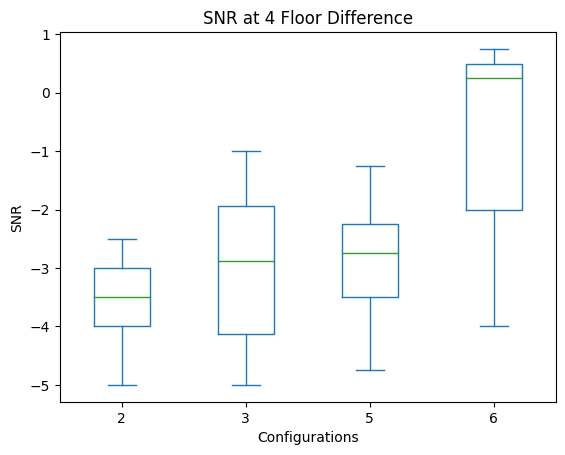

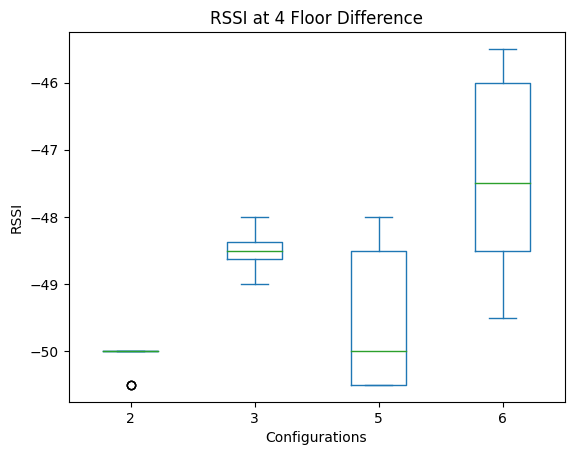

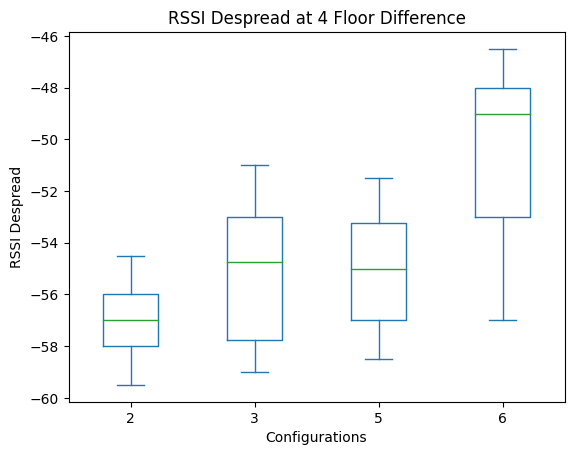

In [213]:
snr_df_4nfloor.plot(kind="box", title="SNR at 4 Floor Difference",ylabel="SNR", xlabel="Configurations")
snr_4n_mean = snr_df_4nfloor.mean()
print("Average SNR For each config:")
print(snr_4n_mean)

rssi_df_4nfloor.plot(kind="box", title="RSSI at 4 Floor Difference",ylabel="RSSI", xlabel="Configurations")
print("Average RSSI For each config:")
rssi_4n_mean = rssi_df_4nfloor.mean()
print(rssi_4n_mean)


rssid_df_4nfloor.plot(kind="box", title="RSSI Despread at 4 Floor Difference",ylabel="RSSI Despread", xlabel="Configurations")
rssid_4n_mean = rssid_df_4nfloor.mean()
print("Average RSSI Despread For each config:")
print(rssid_4n_mean)

Average SNR For each config:
3   -2.979167
6   -0.672414
dtype: float64
Average RSSI For each config:
3   -48.500000
6   -47.258621
dtype: float64
Average RSSI Despread For each config:
3   -55.083333
6   -50.258621
dtype: float64


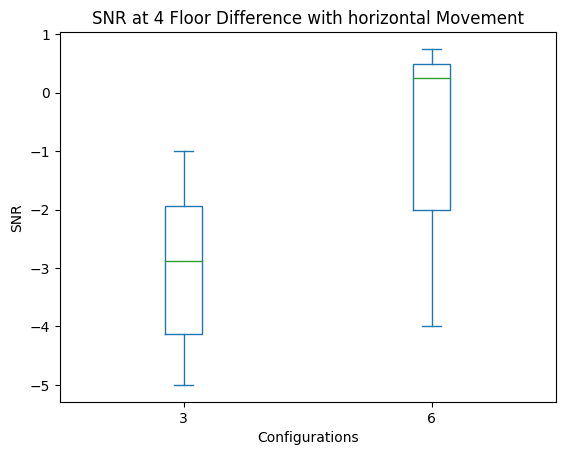

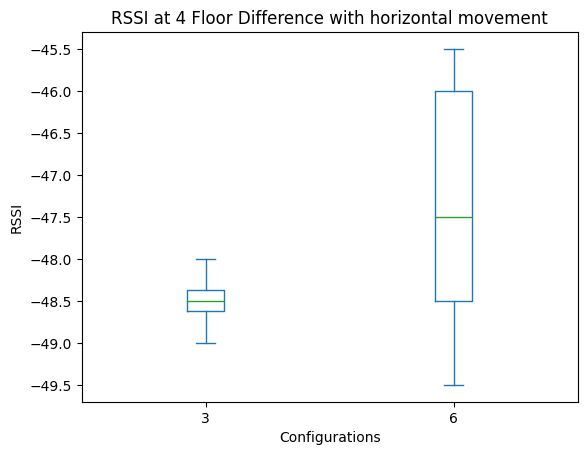

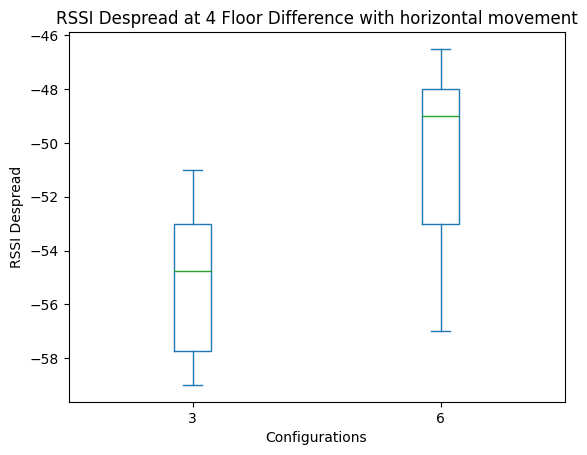

In [214]:
snr_df_4wfloor.plot(kind="box", title="SNR at 4 Floor Difference with horizontal Movement",ylabel="SNR", xlabel="Configurations")
snr_4w_mean = snr_df_4wfloor.mean()
print("Average SNR For each config:")
print(snr_4w_mean)

rssi_df_4wfloor.plot(kind="box", title="RSSI at 4 Floor Difference with horizontal movement",ylabel="RSSI", xlabel="Configurations")
print("Average RSSI For each config:")
rssi_4w_mean = rssi_df_4wfloor.mean()
print(rssi_4w_mean)


rssid_df_4wfloor.plot(kind="box", title="RSSI Despread at 4 Floor Difference with horizontal movement",ylabel="RSSI Despread", xlabel="Configurations")
rssid_4w_mean = rssid_df_4wfloor.mean()
print("Average RSSI Despread For each config:")
print(rssid_4w_mean)

## Consolidating The Indoor Testing Analysis Data

Need to set up the bar graph of success rates for all configurations and all floors

   Floors    Config 1    Config 2   Config 3    Config 4    Config 5  \
0       1  100.000000  100.000000  96.666667   96.551724  100.000000   
1       2   93.333333  100.000000  93.333333  100.000000   96.666667   
2       3   30.000000  100.000000  96.666667  100.000000  100.000000   
3       4    0.000000   66.666667  80.000000   40.000000   83.333333   

    Config 6  
0  96.666667  
1  93.333333  
2  96.666667  
3  96.666667  
   Floors   Config 1   Config 2   Config 3   Config 4   Config 5   Config 6
0       2  13.333333  63.333333  93.333333  80.000000  86.666667  83.333333
1       4   3.333333   6.666667  51.724138   3.333333  41.379310  63.333333


<AxesSubplot: title={'center': 'Consolidated Success Rates, With Horizontal'}, xlabel='Floors', ylabel='Success Rate %'>

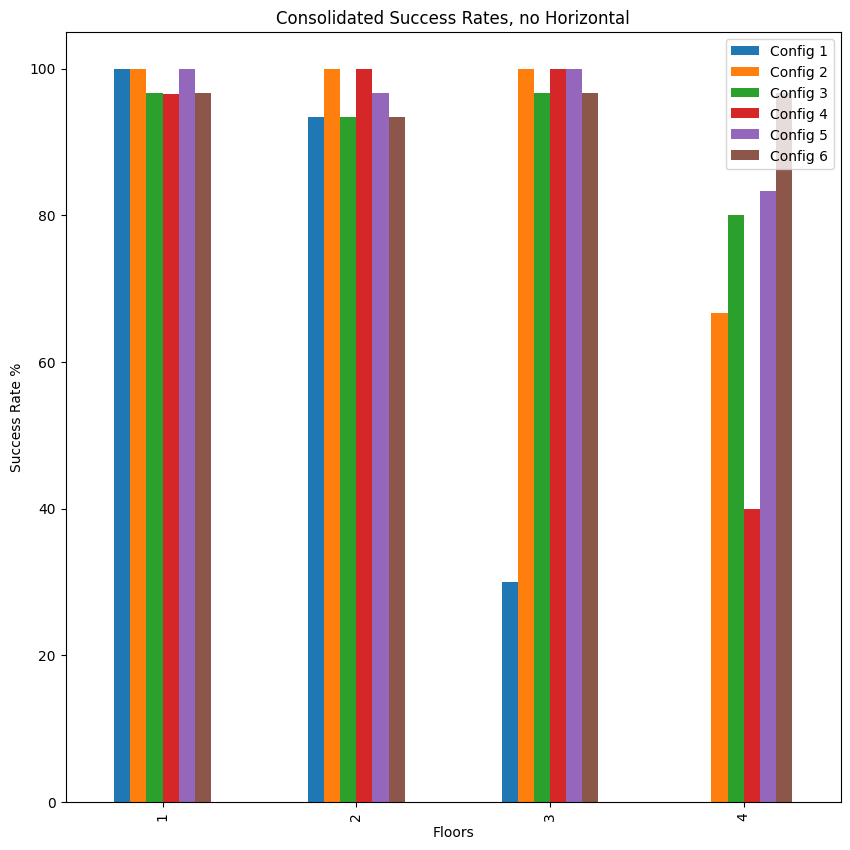

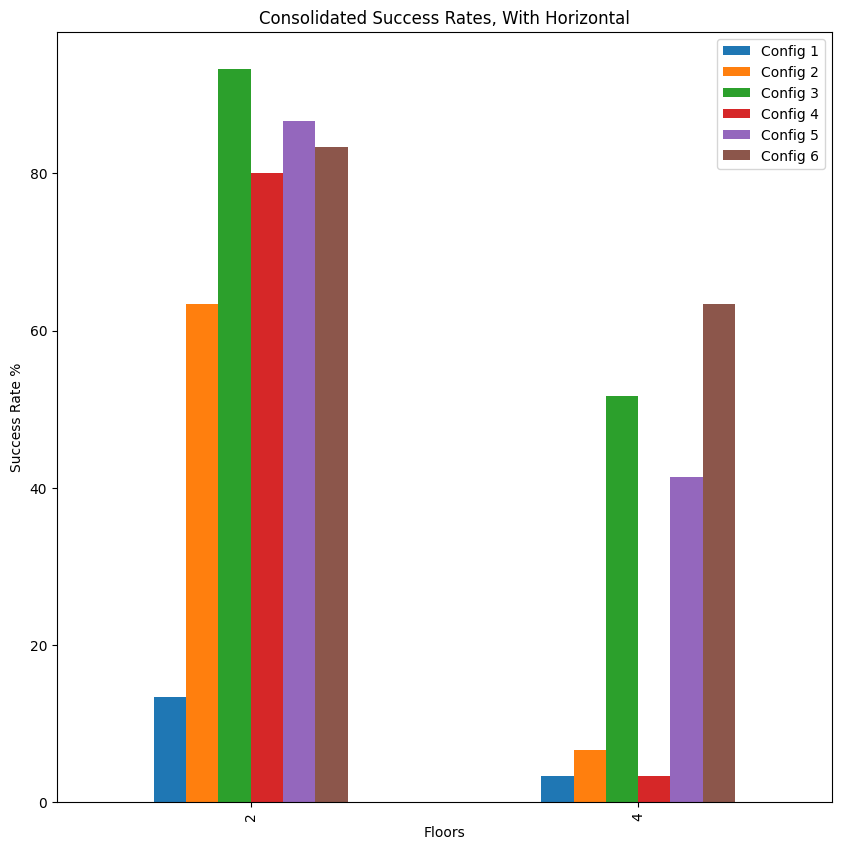

In [215]:
#Initialising the index list and consolidated dictionary
floors = [1,2,3,4]
floorsw = [2,4]
configs = ["Config 1", "Config 2", "Config 3", "Config 4", "Config 5", "Config 6"]
consolidated_success_rate = {}
consolidatedw_success_rate = {}


consolidated_success_rate["Floors"] = floors
consolidatedw_success_rate["Floors"] = floorsw

for config in configs:
    consolidated_success_rate[config] = []
    consolidatedw_success_rate[config] = []


#print(success_rate_df)
#success_rate_df.plot(kind="bar")

############################# No Horizontal Distance ######################################
# creating dictionary for config 1
consolidated_success_rate['Config 1'].append(success_rate_dict['Success Rate'][0])
consolidated_success_rate["Config 1"].append(success_rate2_dict['Success Rate'][0])
consolidated_success_rate["Config 1"].append(success_rate3_dict['Success Rate'][0])
consolidated_success_rate["Config 1"].append(success_rate4n_dict['Success Rate'][0])


# creating dictionary for config 2
consolidated_success_rate['Config 2'].append(success_rate_dict['Success Rate'][1])
consolidated_success_rate["Config 2"].append(success_rate2_dict['Success Rate'][1])
consolidated_success_rate["Config 2"].append(success_rate3_dict['Success Rate'][1])
consolidated_success_rate["Config 2"].append(success_rate4n_dict['Success Rate'][1])


# creating dictionary for config 3
consolidated_success_rate['Config 3'].append(success_rate_dict['Success Rate'][2])
consolidated_success_rate["Config 3"].append(success_rate2_dict['Success Rate'][2])
consolidated_success_rate["Config 3"].append(success_rate3_dict['Success Rate'][2])
consolidated_success_rate["Config 3"].append(success_rate4n_dict['Success Rate'][2])

# creating dictionary for config 4
consolidated_success_rate['Config 4'].append(success_rate_dict['Success Rate'][3])
consolidated_success_rate["Config 4"].append(success_rate2_dict['Success Rate'][3])
consolidated_success_rate["Config 4"].append(success_rate3_dict['Success Rate'][3])
consolidated_success_rate["Config 4"].append(success_rate4n_dict['Success Rate'][3])

# creating dictionary for config 5
consolidated_success_rate['Config 5'].append(success_rate_dict['Success Rate'][4])
consolidated_success_rate["Config 5"].append(success_rate2_dict['Success Rate'][4])
consolidated_success_rate["Config 5"].append(success_rate3_dict['Success Rate'][4])
consolidated_success_rate["Config 5"].append(success_rate4n_dict['Success Rate'][4])

# creating dictionary for config 6
consolidated_success_rate['Config 6'].append(success_rate_dict['Success Rate'][5])
consolidated_success_rate["Config 6"].append(success_rate2_dict['Success Rate'][5])
consolidated_success_rate["Config 6"].append(success_rate3_dict['Success Rate'][5])
consolidated_success_rate["Config 6"].append(success_rate4n_dict['Success Rate'][5])


################################## Horizontal Distanced ##################################

# creating dictionary for config 1
consolidatedw_success_rate["Config 1"].append(success_rate2w_dict['Success Rate'][0])
consolidatedw_success_rate["Config 1"].append(success_rate4w_dict['Success Rate'][0])

# creating dictionary for config 2
consolidatedw_success_rate["Config 2"].append(success_rate2w_dict['Success Rate'][1])
consolidatedw_success_rate["Config 2"].append(success_rate4w_dict['Success Rate'][1])


# creating dictionary for config 3
consolidatedw_success_rate["Config 3"].append(success_rate2w_dict['Success Rate'][2])
consolidatedw_success_rate["Config 3"].append(success_rate4w_dict['Success Rate'][2])

# creating dictionary for config 4
consolidatedw_success_rate["Config 4"].append(success_rate2w_dict['Success Rate'][3])
consolidatedw_success_rate["Config 4"].append(success_rate4w_dict['Success Rate'][3])

# creating dictionary for config 5
consolidatedw_success_rate["Config 5"].append(success_rate2w_dict['Success Rate'][4])
consolidatedw_success_rate["Config 5"].append(success_rate4w_dict['Success Rate'][4])

# creating dictionary for config 6
consolidatedw_success_rate["Config 6"].append(success_rate2w_dict['Success Rate'][5])
consolidatedw_success_rate["Config 6"].append(success_rate4w_dict['Success Rate'][5])


################################ Plotting Results ######################################

#print(consolidated_success_rate)
consolidated_df = pd.DataFrame.from_dict(consolidated_success_rate)
print(consolidated_df)
consolidated_df.plot(kind="bar", x='Floors', title='Consolidated Success Rates, no Horizontal', ylabel="Success Rate %", figsize=[10,10], legend=True)

#print(consolidatedw_success_rate)
consolidatedw_df = pd.DataFrame.from_dict(consolidatedw_success_rate)
print(consolidatedw_df)
consolidatedw_df.plot(kind="bar", x='Floors', title='Consolidated Success Rates, With Horizontal', ylabel="Success Rate %", figsize=[10,10], legend=True)


#sns.barplot(x='Floors', data=consolidated_df)
#plt.legend()
#plt.show()

## Plotting Average SNR and RSSIs in Bar Graph

   Floors  Config 1  Config 2  Config 3  Config 4  Config 5  Config 6
0       1  0.908333  0.375000 -0.715517  1.508621  0.375000 -0.103448
1       2 -0.848214  0.308333  1.517857  2.316667  0.431034  0.651786
2       3 -2.275000 -1.341667  0.448276  0.425000 -0.433333 -0.241379
3       4       NaN -3.571429 -2.979167 -2.125000 -2.898148 -0.672414
   Floors   Config 1   Config 2   Config 3   Config 4   Config 5   Config 6
0       1 -41.650000 -42.716667 -45.258621 -45.586207 -46.933333 -48.948276
1       2 -45.714286 -44.733333 -41.196429 -43.116667 -46.327586 -46.107143
2       3 -48.250000 -49.033333 -46.672414 -48.683333 -49.166667 -48.827586
3       4        NaN -56.928571 -55.083333 -52.666667 -55.148148 -50.258621


<AxesSubplot: title={'center': 'Average RSSI Observed'}, xlabel='Floors', ylabel='RSSI/dB'>

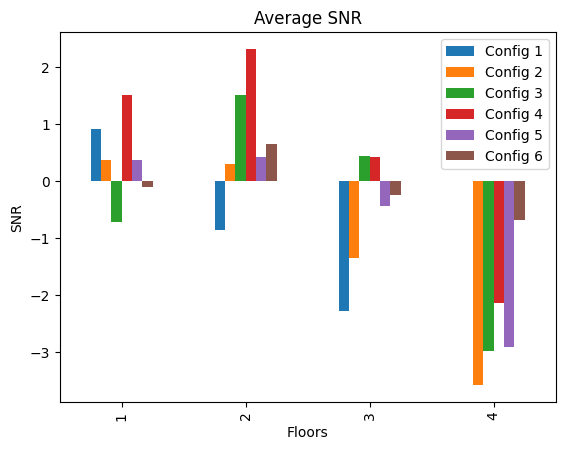

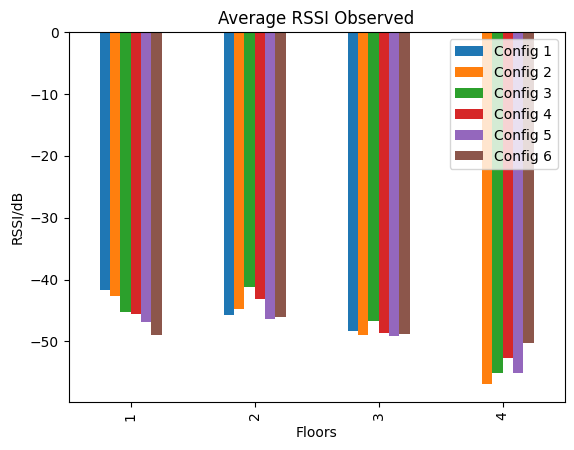

In [216]:
#print("Dictionary of average SNR for all tests:")
#print(average_snr)

#print("Dictionary of average RSSI for all tests:")
#print(average_rssi)


average_snr_df = pd.DataFrame.from_dict(average_snr)
print(average_snr_df)
average_snr_df.plot(kind="bar", x='Floors', title='Average SNR', ylabel="SNR", legend=True)


average_rssi_df = pd.DataFrame.from_dict(average_rssi)
print(average_rssi_df)
average_rssi_df.plot(kind="bar", x='Floors', title="Average RSSI Observed", ylabel="RSSI/dB", legend=True)

   Floors  Config 1  Config 2  Config 3  Config 4  Config 5  Config 6
0       2     -1.25 -4.125000 -1.183333  -1.09375 -2.634615 -2.096154
1       4       NaN -3.571429 -2.979167  -2.12500 -2.898148 -0.672414
   Floors  Config 1   Config 2   Config 3   Config 4   Config 5   Config 6
0       2   -52.375 -58.200000 -51.450000 -50.958333 -54.576923 -53.153846
1       4       NaN -56.928571 -55.083333 -52.666667 -55.148148 -50.258621


<AxesSubplot: title={'center': 'Average RSSI Observed for Horizontal Tests'}, xlabel='Floors', ylabel='RSSI/dB'>

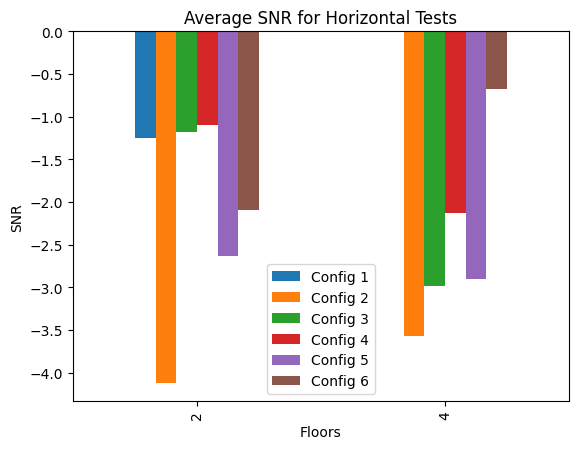

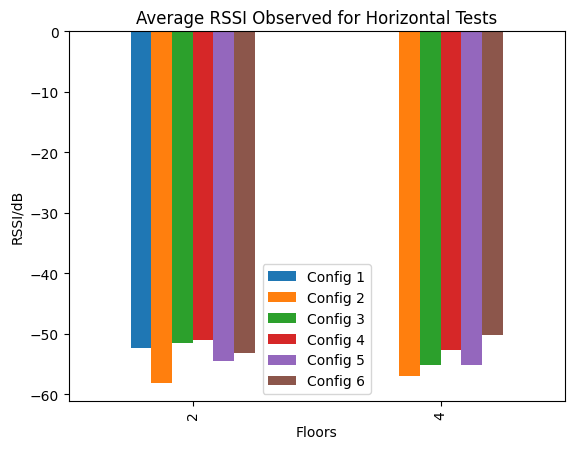

In [217]:
average_snr_horizontal_df = pd.DataFrame.from_dict(average_snr_horizontal)
print(average_snr_horizontal_df)
average_snr_horizontal_df.plot(kind='bar', x='Floors', title='Average SNR for Horizontal Tests', ylabel='SNR', legend=True)


average_rssi_horizontal_df = pd.DataFrame.from_dict(average_rssi_horizontal)
print(average_rssi_horizontal_df)
average_rssi_horizontal_df.plot(kind='bar', x='Floors', title='Average RSSI Observed for Horizontal Tests', ylabel='RSSI/dB', legend=True)

# Outdoor Testing Analysis

## Line of Sight Testing

Comparison of CSV data with real life GPS information to track location of dongle and important points. These points are: 
1. Time the straight starts
2. Time the drive on the straight ends
3. Time the max distance on the straight is found.


The overall plan is to find find those points on the csvs, and then have a dataframe of data between both those times. Hopefully, the rssis/snrs or something will have a parabolic shape. 
The lowest points on the parabola should correspond to furthest point on the map.


Screenshots at key points:
- Max of test 1 and 3, about 5.45km
- Max of test 2, 4 and 5, about 2.8km (evidence of test 1 shows that it can go further)
- Absolute max of Test 6 (5.8km, hopefully graphs will show better)

In [218]:
# Important times of the all tests
# List indexes are Start_time, End_time, Max_time
key_los_points = {"Test 1": ["13:36", "13:49", "13:41" ], "Test 2": ["14:17","14:23","14:19"], "Test 3": ["14:51","15:05","14:56"], "Test 4": ["15:29","15:35","15:32"], "Test 5": ["16:12","16:19","16:15"], "Test 6": ["16:43","17:00","16:51"]}

### Reading CSV and Creating Dataframes
Following lines of code reads the six test csvs into a dataframe, then cuts the dataframe to the specific sections of the straight of baden powell drive for further processing.

In [219]:
#print(line_of_sight_info.loc[0])
los_dfs = [] #line of sight dataframes
for index, row in line_of_sight_info.iterrows():
    #obtaining test file
    test_num = "Test " + str(row["Test Number"])
    print(test_num)
    name = "outdoor_los/Test_" + str(row["Test Number"]) + ".csv"
    los_df = pd.read_csv(name)


    # Getting the rows that correspond to start and end of straight road
    los_df_start = los_df[los_df['Timestamp'].str.lower().str.contains(key_los_points[test_num][0])]
    los_df_end = los_df[los_df['Timestamp'].str.lower().str.contains(key_los_points[test_num][1])]

    # filtering out the main df to only contain the rows in between these two points
    start_index = los_df_start.index.to_list()[0]
    #print(start_index)
    end_index = los_df_end.index.to_list()[-1] + 1
    #print(end_index)

    los_df = los_df.iloc[start_index:end_index]
    #print(los_df)
    
    #saving new dataframe to list
    los_dfs.append(los_df)



Test 1
Test 2
Test 3
Test 4
Test 5
Test 6


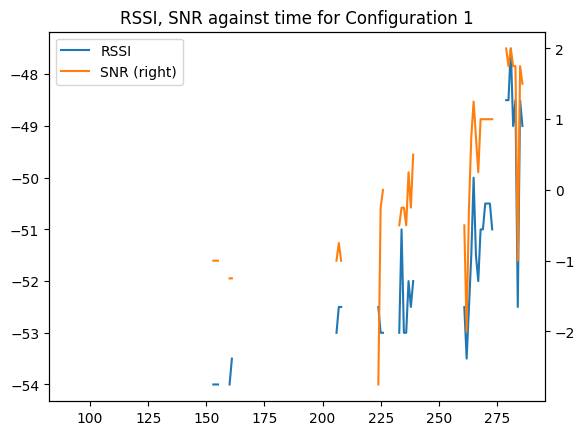

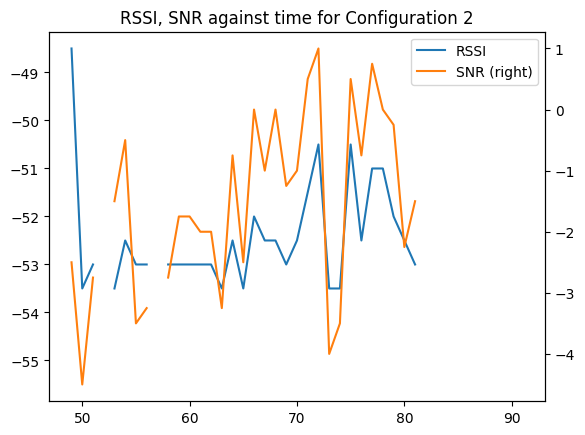

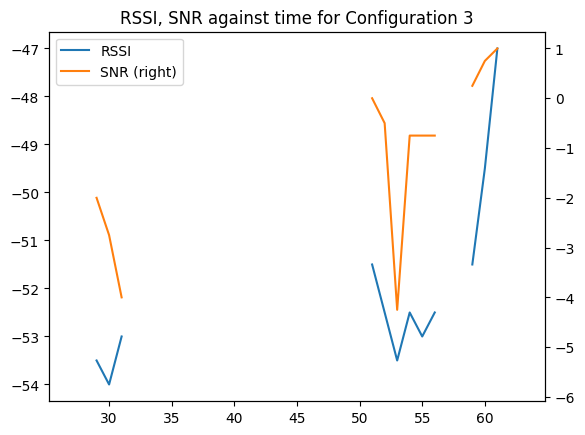

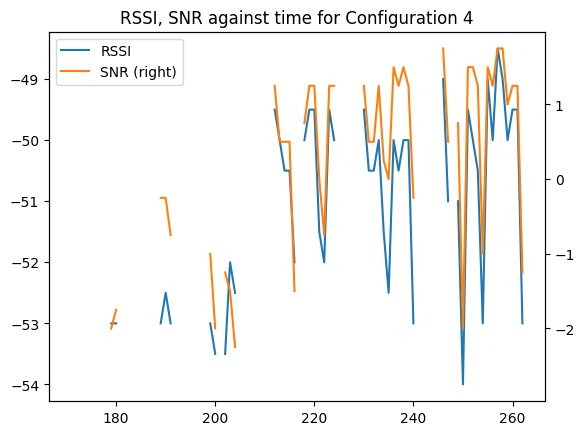

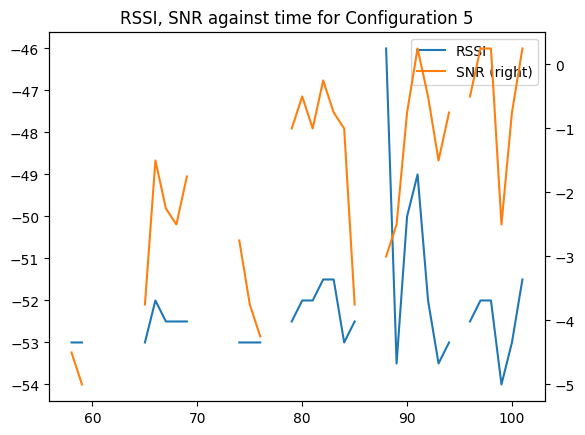

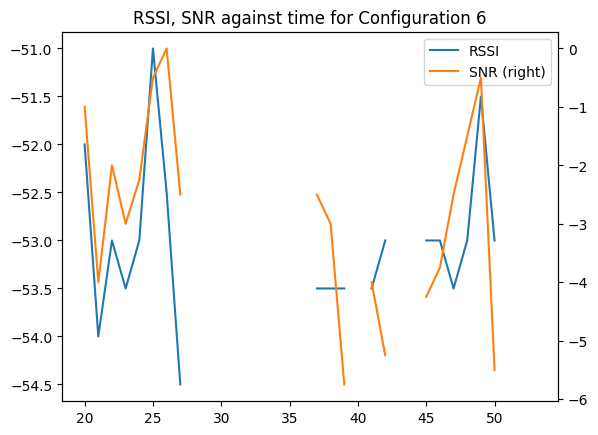

In [220]:
# Attempt at visualising data
index = 1
for los_df in los_dfs:
    title = "RSSI, SNR against time for Configuration " + str(index)
    #los_df[['RSSI', 'SNR']].plot(title=title)
    #los_df.plot(title=title, x="Timestamp", y="RSSI")
    los_df[['RSSI', 'SNR']].plot(title=title, secondary_y='SNR')
    index+=1

Looks as though the plots aren't that great. Still trying to figure out how to do this. Seems the RSSI and SNR goes down to a certain level and then stays at that level.

What is the best way to show the data obtained?
- Side by side screenshots of gps data and map distance? 
- Snippets of the csvs at max distance?
- Average success rate while on the straight?